In [1]:
#import pairs_backtest as pb
import talib 
import numpy as np
import datetime as dt #in-built module
import pandas as pd
from pandas_datareader import data
import yfinance as yf
from yahoo_fin import stock_info as si
import matplotlib.pyplot as plt
from matplotlib import style
from pathlib import Path
import os
from tqdm import tqdm   
from pairs_backtest import kalman_lib as kalman
from pairs_backtest import find_pairs
from pairs_backtest import utils
from pandas_datareader import data as pdr
import statsmodels.tsa.stattools as ts

In [2]:
def get_data(code,start,end):
    data = yf.Ticker(code)
    data = data.history(start = start, end = end)
    #data.index = data.index.strftime('%d/%m/%Y')
    return data

In [3]:
date = dt.datetime.now()
date ='%s_%s_%s'%(date.year,date.month,date.day)
backtest_day = 730
market = 'US'

#end = pd.Timestamp('2023-12-07')
end = dt.date.today()

#start = dt.datetime.now()- dt.timedelta(days=backtest_day)
start = end- dt.timedelta(days=backtest_day)
#end = dt.datetime.now()

#start = pd.Timestamp('2012-01-01')
#end = pd.Timestamp('2023-12-01')
#end = dt.date.today()

if not os.path.exists('for_testing'):
  os.makedirs('for_testing')
first_inst = 'ROL'
second_inst = 'XYL'
combin_df = pd.DataFrame()

x_df = get_data(first_inst,start,end)
y_df = get_data(second_inst,start,end)
common_index = (x_df.index).intersection(y_df.index)
x_df = x_df.loc[common_index].copy()
y_df = y_df.loc[common_index].copy()

result = ts.coint(((x_df['Close'])),(y_df['Close']))
score = result[0]
pvalue = result[1]

print('Score:', score)
print('pvalue:', pvalue)

df, sharpe, _ = kalman.backtest(x_df.Close, y_df.Close) #df1 = x; df2 = y
df = df.dropna()
df.to_csv('for_testing/%s_%s.csv'%(first_inst,second_inst))
print ('%s vs %s has sharp ratio of %0.2f' %(first_inst,second_inst,sharpe))
print (df.tail()[['y','x','hr','numUnits']])

Score: -2.886212784707476
pvalue: 0.13978784065311128
ROL vs XYL has sharp ratio of 1.92
                                    y          x        hr  numUnits
Date                                                                
2023-12-11 00:00:00-05:00  107.699997  41.630001 -2.480615       0.0
2023-12-12 00:00:00-05:00  107.940002  42.049999 -2.481649       0.0
2023-12-13 00:00:00-05:00  109.180000  43.470001 -2.479177       0.0
2023-12-14 00:00:00-05:00  110.930000  42.740002 -2.480427       0.0
2023-12-15 00:00:00-05:00  110.720001  42.150002 -2.484700      -1.0


In [4]:
def py_plot(df1,date,first_instrument,second_instrument):
    if not os.path.exists('py_plot'):
        os.makedirs('py_plot')

    path = 'py_plot'

    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, figsize=(14,20))
    df1['X_sell_price'] = df1[df1['numUnits']==1]['x']
    df1['Y_Buy_price'] = df1[df1['numUnits']==1]['y']
    df1['X_Buy_price'] = df1[df1['numUnits']==-1]['x']
    df1['Y_sell_price'] =df1[df1['numUnits']==-1]['y']


    ax1 = df1[['x','y']].plot(ax=ax1)
    ax1.scatter(df1.index , df1['Y_Buy_price'] , label = 'Buy' , marker = '^', color = 'green',alpha =1 )
    ax1.scatter(df1.index , df1['X_sell_price'] , label = 'Sell' , marker = 'v', color = 'red',alpha =1 )
    ax1.scatter(df1.index , df1['X_Buy_price'] , label = 'Buy' , marker = '^', color = 'green',alpha =1 )
    ax1.scatter(df1.index , df1['Y_sell_price'] , label = 'Sell' , marker = 'v', color = 'red',alpha =1 )
    ax2 = df1[['cum rets']].plot(ax = ax2)
    #df['p_value'].plot(ax = ax2)
    df1['zScore']= df1['zScore'].fillna(0)
    ax3= df1['zScore'].plot(ax = ax3)
    ax2.axhline(y = 1, color = 'r', linestyle = 'dashed')
    ax3.axhline(y = 1.5, color = 'r', linestyle = 'dashed')
    ax3.axhline(y = -1.5, color = 'r', linestyle = 'dashed')
    ax1.grid()
    ax2.grid()
    ax3.grid()
    ax1.legend()
    #plt.tight_layout()
    #plt.show()
    #plt.savefig(path+'/%s vs %s_%s.jpeg'%(first_instrument,second_instrument,date))
    #plt.close('all')
    return ax1,ax2,ax3

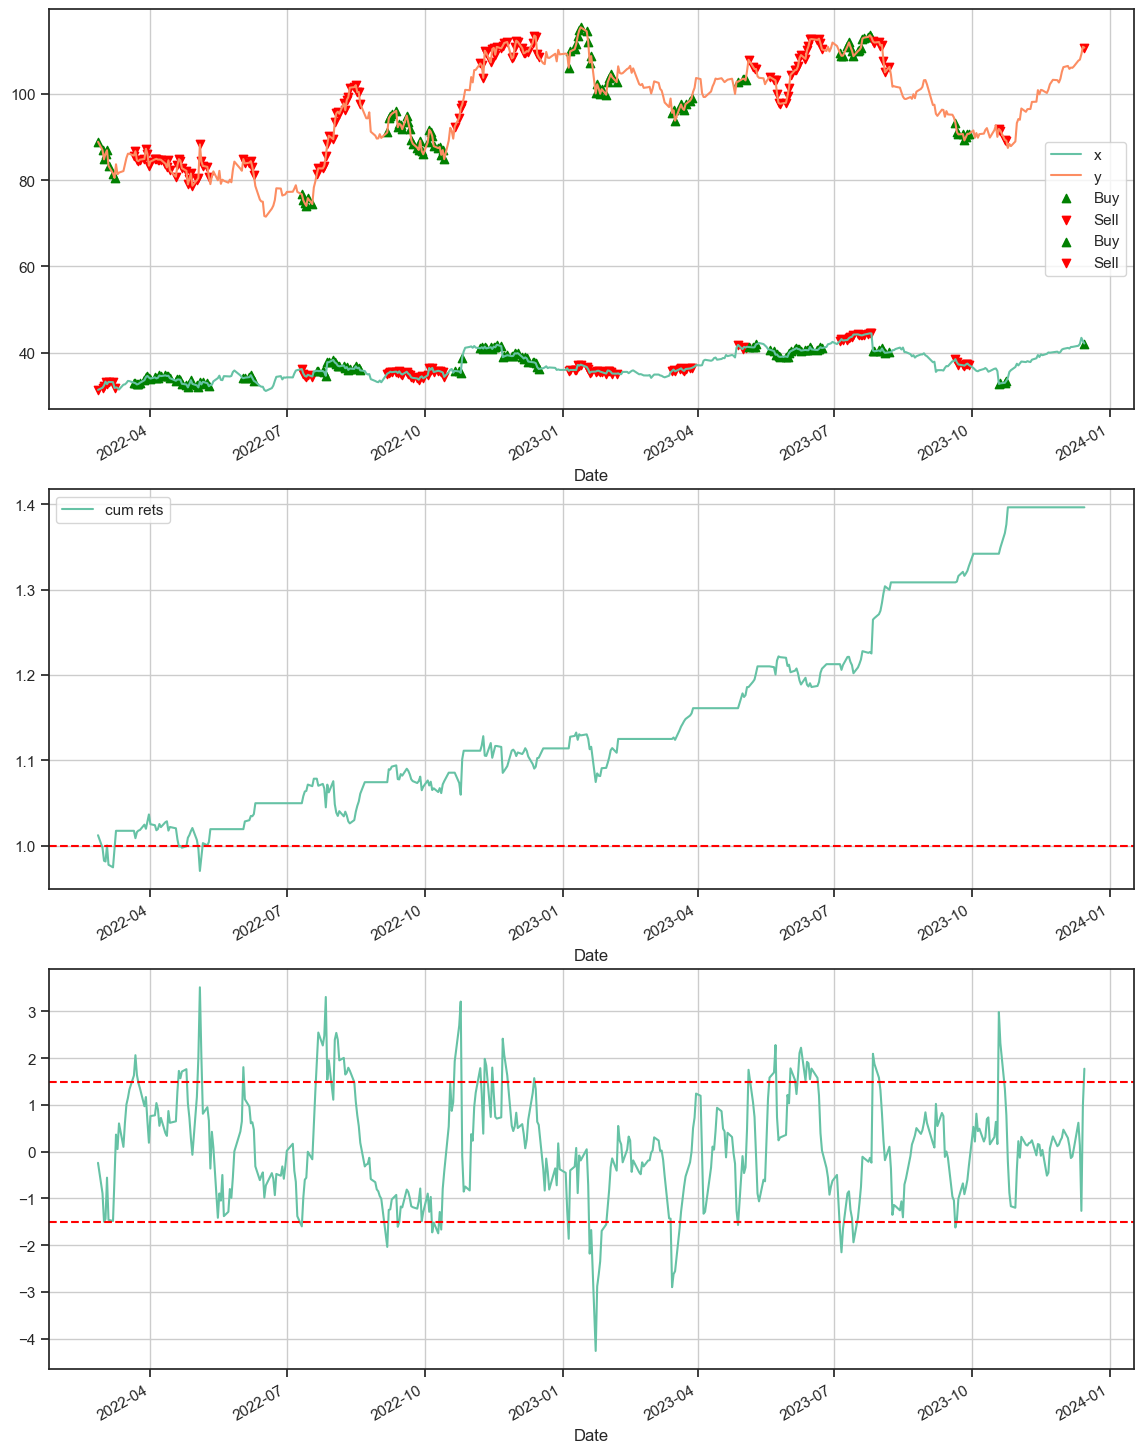

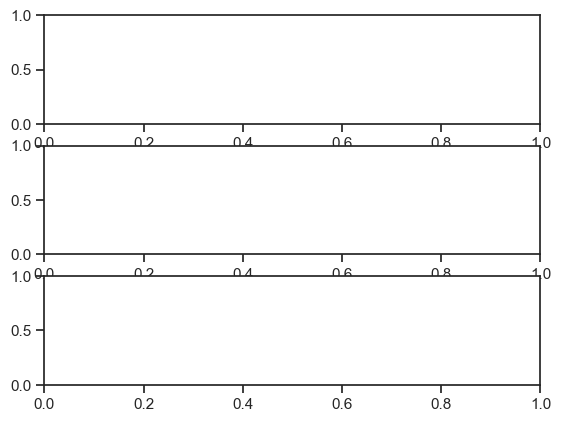

In [5]:
axes_tuple = py_plot(df,date,first_inst,second_inst)
# Plot the axes directly
fig, axs = plt.subplots(3, 1)  # Create a figure with 3 subplots
axs[0] = axes_tuple[0].plot()
axs[1] = axes_tuple[1].plot()
axs[2] = axes_tuple[2].plot()

# Display the plots
#plt.tight_layout()  # Adjust the spacing between subplots
#plt.show()


In [6]:
plt.close()

In [7]:
df.tail()

,y,x,hr,spread,zScore,long entry,long exit,num units long,short entry,short exit,num units short,numUnits,spread pct ch,port rets,cum rets,X_sell_price,Y_Buy_price,X_Buy_price,Y_sell_price
Date,,,,,,,,,,,,,,,,,,,
2023-12-11 00:00:00-05:00,107.699997,41.630001,-2.480615,4.431998,0.619,False,True,0.0,False,False,0.0,0.0,0.003542,0.0,1.396321,NaN,NaN,NaN,NaN
2023-12-12 00:00:00-05:00,107.940002,42.049999,-2.481649,3.586650,0.134,False,False,0.0,False,False,0.0,0.0,-0.003982,-0.0,1.396321,NaN,NaN,NaN,NaN
2023-12-13 00:00:00-05:00,109.180000,43.470001,-2.479177,1.410194,-1.265,False,False,0.0,False,True,0.0,0.0,-0.010032,-0.0,1.396321,NaN,NaN,NaN,NaN
2023-12-14 00:00:00-05:00,110.930000,42.740002,-2.480427,4.916546,0.983,False,True,0.0,False,False,0.0,0.0,0.016163,0.0,1.396321,NaN,NaN,NaN,NaN
2023-12-15 00:00:00-05:00,110.720001,42.150002,-2.484700,5.989896,1.775,False,False,0.0,True,False,-1.0,-1.0,0.004982,0.0,1.396321,NaN,NaN,42.150002,110.720001
